# Generate permutations

In [1]:
import itertools
import random
import numpy as np
from scipy.spatial.distance import hamming

# Seed for random number generation
random.seed(42)

# Create a list of all possible permutations of 9 elements
all_permutations = list(itertools.permutations(range(9)))
all_permutations_array = np.array(all_permutations)
total_permutations = len(all_permutations)

# Define the number of permutations to select
permutations_to_select = 1000

# Create a set to keep track of selected permutations
selected_permutations = set()
iteration_count = 0

while True:
    iteration_count += 1

    # Generate random indices for two permutations
    index_1 = random.randint(1, total_permutations - 1)
    index_2 = random.randint(1, total_permutations - 1)

    # Retrieve the selected permutations
    permutation_1 = all_permutations_array[index_1]
    permutation_2 = all_permutations_array[index_2]

    # Calculate the Hamming distance between the selected permutations
    hamming_distance = hamming(permutation_1, permutation_2)

    # Check if the Hamming distance is above a threshold and the permutations have not been selected before
    if hamming_distance > 0.9 and index_1 not in selected_permutations and index_2 not in selected_permutations:
        selected_permutations.add(index_1)
        selected_permutations.add(index_2)

        # Check if we have reached the desired number of selected permutations
        if len(selected_permutations) == permutations_to_select:
            break

print("Number of iterations it took to build the top {} permutations array = {}".format(permutations_to_select, iteration_count))
print("Number of selected permutations:", len(selected_permutations))

Number of iterations it took to build the top 1000 permutations array = 1411
Number of selected permutations: 1000


In [2]:
# Build the array for selected permutation indices above
selected_permuts = []
for ind, perm_id in enumerate(selected_permutations):
    if ind < 10:
        print ("Sample permutation {}".format(ind))
        print (all_permutations_array[perm_id])
    selected_permuts.append(all_permutations_array[perm_id])

selected_permuts = np.array(selected_permuts)
np.save('Data/selected_permuts.npy', selected_permuts)


Sample permutation 0
[2 5 7 0 4 1 3 6 8]
Sample permutation 1
[5 3 8 1 2 0 7 4 6]
Sample permutation 2
[2 3 4 0 1 5 8 6 7]
Sample permutation 3
[0 1 7 6 2 8 5 3 4]
Sample permutation 4
[0 5 8 1 7 2 6 4 3]
Sample permutation 5
[8 1 0 2 6 7 4 3 5]
Sample permutation 6
[4 6 7 3 1 5 8 0 2]
Sample permutation 7
[1 8 6 7 4 5 2 3 0]
Sample permutation 8
[4 8 6 5 3 2 1 0 7]
Sample permutation 9
[8 4 5 6 2 1 0 3 7]


# Generate Jigsaw of Image from permutations

In [3]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset
from src.Dataset_process import crop_center,get_nine_crops


class GetDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, labels, transform=None):
        'Initialization'
        self.imgs = [(img_path, label) for img_path, label in zip(file_paths, labels)]
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        label = self.labels[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            label = self.labels[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        tr_image = self.transform(pil_image)

        return tr_image, label


class GetJigsawPuzzleDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, avail_permuts_file_path, range_permut_indices=None, transform=None):
        'Initialization'
        self.file_paths = file_paths
        self.transform = transform
        self.permuts_avail = np.load(avail_permuts_file_path)
        self.range_permut_indices = range_permut_indices

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        pil_image = Image.open(file_path)
        orig_image = pil_image
        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        pil_image = pil_image.resize((128, 128))
        pil_image = crop_center(pil_image, 105, 105)

        # Get nine crops for the image
        nine_crops = get_nine_crops(pil_image)

        # Permut the 9 patches obtained from the image
        if self.range_permut_indices:
            permut_ind = random.randint(self.range_permut_indices[0], self.range_permut_indices[1])
        else:
            permut_ind = random.randint(0, len(self.permuts_avail) - 1)

        permutation_config = self.permuts_avail[permut_ind]

        permuted_patches_arr = [None] * 9
        for crop_new_pos, crop in zip(permutation_config, nine_crops):
            permuted_patches_arr[crop_new_pos] = crop

        # Apply data transforms
        tensor_patches = torch.zeros(9, 3, 32, 32)
        for ind, jigsaw_patch in enumerate(permuted_patches_arr):
            jigsaw_patch_tr = self.transform(jigsaw_patch)
            tensor_patches[ind] = jigsaw_patch_tr

        return tensor_patches, permut_ind


# Custom CNN Model for JIGSAW Self supervised Pre-training task

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Map to a 1000-dimensional vector
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        # x = self.relu3(self.conv3(x))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu4(self.fc1(x))
        return x
    
class SelfSupervisedModel(nn.Module):
    def __init__(self, siamese_deg=None,num_outputs=1000):
        super(SelfSupervisedModel, self).__init__()
        self.siamese_deg = siamese_deg
        self.patch_model = CNNModel()
        self.fc2 = nn.Linear(9 * 512, 4096)  # Concatenate the outputs from all patches
        self.fc3 = nn.Linear(4096, num_outputs)  # Output layer (can serve as self.output)

        # if siamese_deg == None:
        #     self.fc2 = nn.Linear(512,num_outputs)

    def forward(self, input_batch):
        # print('reach')
        #Downstream task layer
        if self.siamese_deg is None:
            # print(input_batch.shape)
            batch_features = self.patch_model(input_batch)
            # print("batch: ",batch_features.shape)
            x = self.fc2(batch_features)
            # print("last x: ",x.shape)
            x = F.log_softmax(x)
            return x
        # print('out')
        #self supervised learning
        batch_size, num_patches, channels, height, width = input_batch.size()

        
        final_feat_vectors = None
        
        for patch_ind in range(self.siamese_deg):
            # Each patch_batch would be of shape (batch_size, color_channels, h_patch, w_patch)
            patch_batch = input_batch[:, patch_ind, :, :, :]
            patch_batch_features = self.patch_model(patch_batch)

            if patch_ind == 0:
                final_feat_vectors = patch_batch_features
            else:
                final_feat_vectors = torch.cat([final_feat_vectors, patch_batch_features], dim=1)
        
        # Use fc3 as the output layer
        x = self.fc2(final_feat_vectors)
        x = F.log_softmax(self.fc3(x))
        # x = F.log_softmax(x)
        
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Initialize your self-supervised model
self_supervised_model = SelfSupervisedModel(siamese_deg=9,num_outputs=1000)  # Replace 'siamese_deg' with the actual value

print(self_supervised_model)

# Calculate the number of parameters
total_params = count_parameters(self_supervised_model)
print(f"Total model parameters: {total_params//1000000}M")

# Print the model architecture


SelfSupervisedModel(
  (patch_model): CNNModel(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (fc1): Linear(in_features=4096, out_features=512, bias=True)
    (relu4): ReLU()
  )
  (fc2): Linear(in_features=4608, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=1000, bias=True)
)
Total model parameters: 25M


# Jigsaw as pretext task training

In [7]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torchvision.transforms import transforms
from src.Dataset_process import get_paths
from src.trainer import JigsawModelTrainTest,ModelTrainTest
from torch.nn.parallel import DataParallel



Cexperiment_name = 'CIFAR-10'
Cweight_decay = 5e-4
Clr = 1e-2
Cepochs = 20
Cbatch_size = 32

# Data files which will get referred
permuts_file_path = 'Data/selected_permuts.npy'

# Set device to use to gpu if available and declare model_file_path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_file_path = 'Model/jigsaw_solver_{}_trained.pt'.format(Cexperiment_name)

all_file_paths = get_paths()

# Get validation files separate
train_file_paths, val_file_paths = train_test_split(all_file_paths, test_size=0.1, shuffle=True, random_state=3)

# Compute channel means
channel_means = np.array([124.09, 127.67, 110.50]) / 256.0

# Define data transforms
data_transform = transforms.Compose([
    transforms.RandomCrop((32, 32)),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define data loaders
batch_size = Cbatch_size


train_data_loader = DataLoader(
    GetJigsawPuzzleDataset(train_file_paths, permuts_file_path, transform=data_transform),
    batch_size=batch_size, shuffle=True, num_workers=8
)
val_data_loader = DataLoader(
    GetJigsawPuzzleDataset(val_file_paths, permuts_file_path, transform=data_transform),
    batch_size=batch_size, shuffle=True, num_workers=8
)

print("Loaders done")

Loaders done


In [8]:
import matplotlib.pyplot as plt

import random
import matplotlib.pyplot as plt
from PIL import Image


def create_permuted_image(patch_grid):
    # Assuming that patch_grid is a list of 9 PIL images
    # Create a 3x3 grid of patches
    width, height = patch_grid[0].size
    permuted_image = Image.new("RGB", (width * 3, height * 3))

    for i in range(3):
        for j in range(3):
            permuted_image.paste(patch_grid[i * 3 + j], (j * width, i * height))

    return permuted_image

def visualization(file_paths, permuts_avail):
    num_images = 32
    rows = 8
    cols = 4

    original_image_grid = Image.new("RGB", (cols * 128, rows * 128))
    permuted_image_grid = Image.new("RGB", (cols * 128, rows * 128))

    for i in range(num_images):
        ind = random.randint(0, len(file_paths) - 1)
        file_path = file_paths[ind]
        pil_image = Image.open(file_path)

        # Convert image to torch tensor and get nine crops
        pil_image = pil_image.resize((128, 128))
        pil_image = crop_center(pil_image, 105, 105)

        nine_crops = get_nine_crops(pil_image)

        # Determine the grid position for the current image
        row_num = i // cols
        col_num = i % cols

        # Display the original image on the left
        original_image_grid.paste(pil_image, (col_num * 128, row_num * 128))

        # Permute the 9 patches obtained from the image
        permut_ind = random.randint(0, len(permuts_avail) - 1)
        permutation_config = permuts_avail[permut_ind]

        permuted_patches = [None] * 9
        for crop_new_pos, crop in zip(permutation_config, nine_crops):
            permuted_patches[crop_new_pos] = crop

        permuted_image = create_permuted_image(permuted_patches)

        # Display the permuted patch grid on the right
        permuted_image_grid.paste(permuted_image, (col_num * 128, row_num * 128))

    # Display the combined original image grid and permuted image grid side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
    axes[0].imshow(original_image_grid)
    axes[0].set_title("Original Images")
    axes[0].axis('off')
    axes[1].imshow(permuted_image_grid)
    axes[1].set_title("Permuted Patches")
    axes[1].axis('off')

    plt.show()


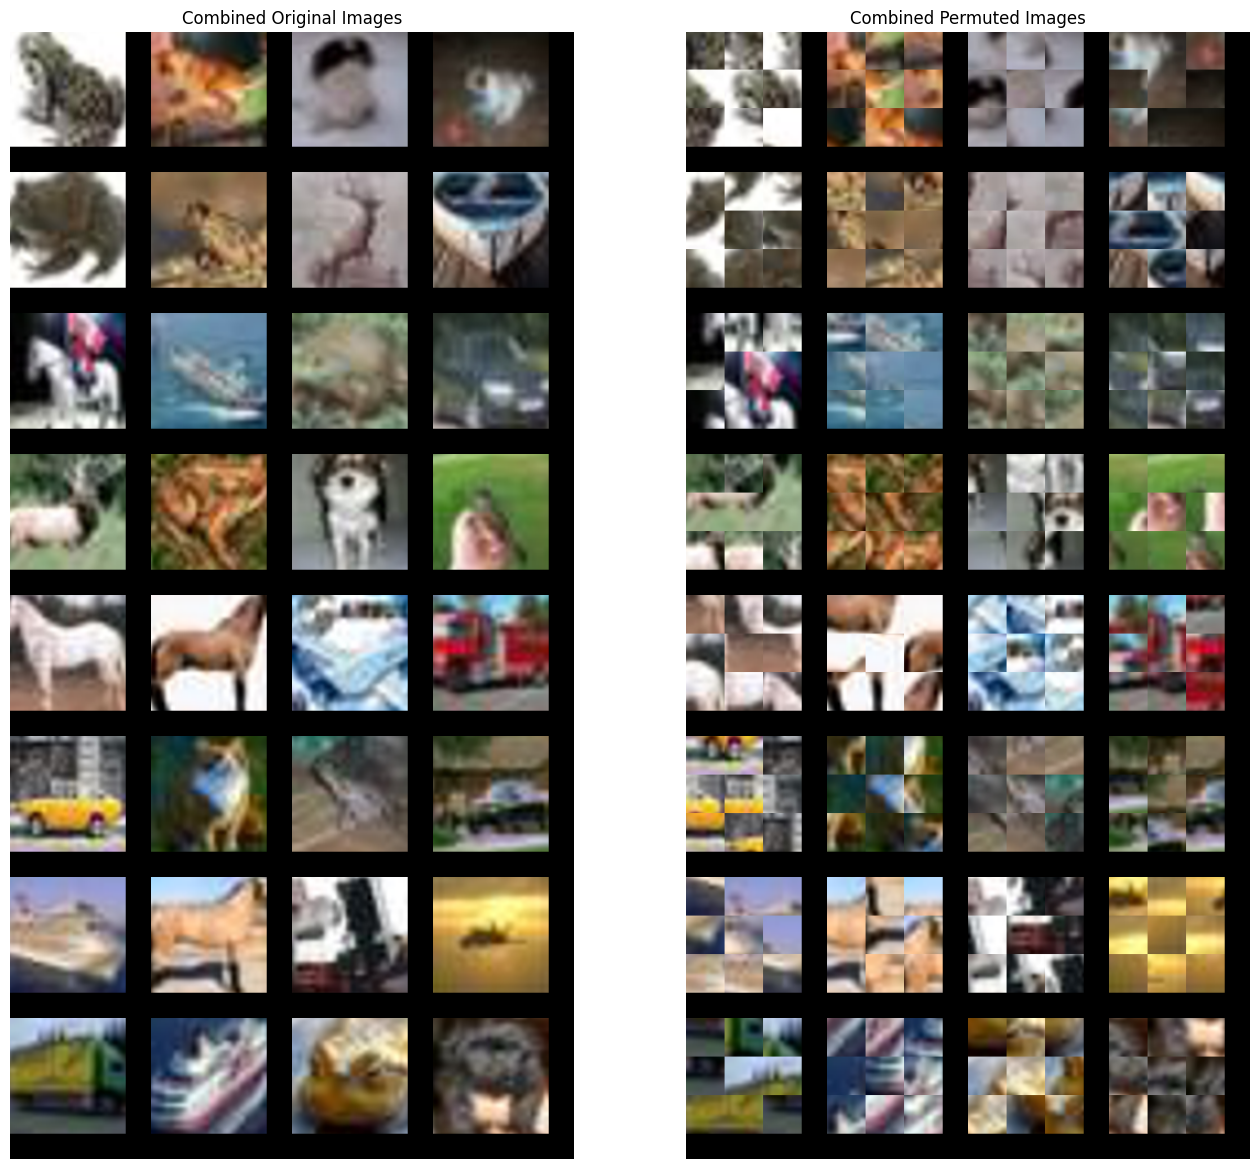

In [10]:
visualization(train_file_paths,np.load(permuts_file_path))

In [11]:
num_outputs = 1000
epochs = Cepochs
lr = Clr
weight_decay_const = Cweight_decay

jigsawSSL = SelfSupervisedModel(siamese_deg=9,num_outputs=1000)  # Replace 'siamese_deg' with the actual value
if torch.cuda.device_count()>1:
        jigsawSSL = nn.DataParallel(jigsawSSL)
print('Model ready')
# Set device on which training is done. Plus optimizer to use.
jigsawSSL.to(device)
optimizer = optim.SGD(jigsawSSL.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-5)

# Start training
print('Started training')
model_train_test_obj = JigsawModelTrainTest(jigsawSSL, device, model_file_path)
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch_no in range(epochs):
    print("Epoch no {} #######################".format(epoch_no))
    train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
        optimizer, epoch_no, params_max_norm=4,
        train_data_loader = train_data_loader, val_data_loader = val_data_loader
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print("Train loss {} \n Val loss {} \n Train Acc {} \n Val Acc {}".format(train_loss,val_loss,train_acc*100,val_acc*100))
    scheduler.step(val_loss)

Model ready
Started training
Epoch no 0 #######################


/tmp/ipykernel_1011014/516152623.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))
/home/raj/GNR-650/Assignment_3/src/trainer.py:146: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Aepoch 0 - Validation set: Average loss: 6.9081, Accuracy: 6/5000 (0%)


epoch 0 - Train set: Average loss: 6.9083, Accuracy: 54/45000 (0%)

Train loss 6.908338879217217 
 Val loss 6.9080597686767575 
 Train Acc 0.12 
 Val Acc 0.12
Epoch no 1 #######################

Aepoch 1 - Validation set: Average loss: 6.9085, Accuracy: 4/5000 (0%)


epoch 1 - Train set: Average loss: 6.9081, Accuracy: 44/45000 (0%)

Train loss 6.908097533867896 
 Val loss 6.908455432128906 
 Train Acc 0.09777777777777777 
 Val Acc 0.08
Epoch no 2 #######################

Aepoch 2 - Validation set: Average loss: 6.9032, Accuracy: 9/5000 (0%)


epoch 2 - Train set: Average loss: 6.9073, Accuracy: 59/45000 (0%)

Train loss 6.907296146156946 
 Val loss 6.903183657836914 
 Train Acc 0.13111111111111112 
 Val Acc 0.18
Epoch no 3 #######################

Aepoch 3 - Validation set: Average loss: 6.7117, Accuracy: 71/5000 (1%)


epoch 3 - Train set: Average loss: 6.8233, Accuracy: 218/45000 (0%)

Train loss 6.82334020210

# Plot loss and accuracy curves

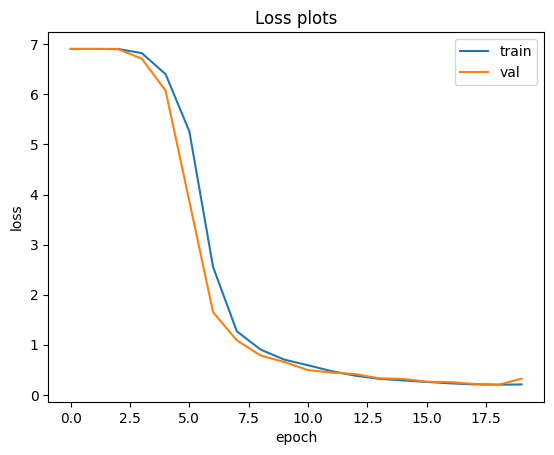

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('Plots/loss.jpg')

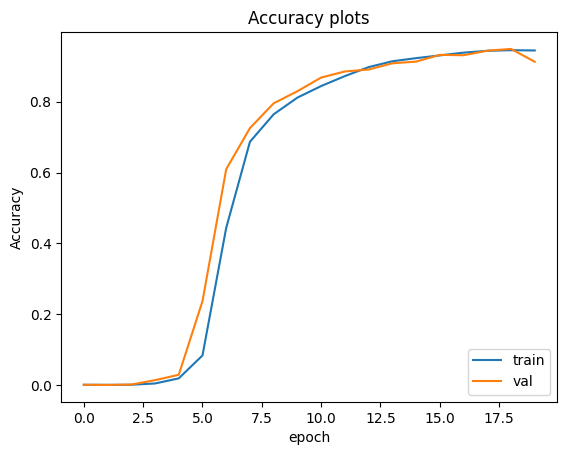

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.show()
plt.savefig('Plots/accuracy.jpg')

# Downstream classification training

In [14]:
from torchvision import transforms
normal_data_transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    # transforms.CenterCrop((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [22]:
#for downstream classification
import argparse
import os

import torch
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, ConcatDataset,random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils, models
from src.trainer import ModelTrainTest

torch.manual_seed(42)


    batch_size = 32
    Cepochs = 25
    Coptim = 'adam'
    Clr = 1e-4
    Cweight_decay = 5e-4
    
    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_dataset = ImageFolder(root='CIFAR-10-images/train',transform=normal_data_transform)
    test_dataset = ImageFolder(root='CIFAR-10-images/test',transform=normal_data_transform)

    # Define the size for the validation set
    val_size = 5000  # You can adjust this size as needed
    # Calculate the size of the training set (excluding the validation set)
    train_size = len(train_dataset) - val_size

    # Split the training dataset into training and validation sets
    train_set, val_set = random_split(train_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size,shuffle=True)
    val_loader =  torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size,shuffle=False)
    test_loader =  torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

    # Train required model defined above on CUB200 data
    num_classes = 10
    epochs = Cepochs
    lr = Clr
    weight_decay_const = Cweight_decay

    model_to_train = SelfSupervisedModel(siamese_deg=None)

    checkpoint_path = 'Model/jigsaw_solver_CIFAR-10_trained.pt'
    model_file_path = 'Model/jigsaw_downstream_image_recognition.pt'
    
    checkpoint = torch.load(checkpoint_path)
    print(checkpoint.keys())
    
    new_checkpoint = {}

    # Iterate through the keys in the loaded checkpoint
    for key, value in checkpoint.items():
        # Modify the key to match the existing model's module name
        new_key = key.replace('module.', '')  # Remove 'module.' prefix if it exists
        new_checkpoint[new_key] = value

    model_to_train.load_state_dict(new_checkpoint)
    model_to_train.fc2 = nn.Linear(512,num_classes)
    
    # print(model_to_train)
    # Load state dict for pre trained model weights
    
    print('Model loaded successfully')

    # Set device on which training is done. Plus optimizer to use.
    if torch.cuda.device_count()>1:
        model_to_train = nn.DataParallel(model_to_train)
        
    model_to_train.to(device)

    for name, param in model_to_train.named_parameters():
        # print(name)
        if name in ['module.fc2.weight', 'module.fc2.bias','module.patch_model.conv3.weight','module.patch_model.conv3.bias','module.patch_model.fc1.weight','module.patch_model.fc1.bias']:
            param.requires_grad = True
        else:
            param.requires_grad = False

    
    sgd_optimizer = optim.SGD(model_to_train.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
    adam_optimizer = optim.Adam(model_to_train.parameters(), lr=lr, weight_decay=weight_decay_const)

    if Coptim == 'sgd':
        optimizer = sgd_optimizer
    else:
        optimizer = adam_optimizer

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-5)

    # Start training
    model_train_test_obj = ModelTrainTest(model_to_train, device, model_file_path)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    print('Training started')
    for epoch_no in range(epochs):
        train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
            optimizer, epoch_no, params_max_norm=4,
            train_data_loader=train_loader, val_data_loader=val_loader
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        scheduler.step(val_loss)

odict_keys(['module.patch_model.conv1.weight', 'module.patch_model.conv1.bias', 'module.patch_model.conv2.weight', 'module.patch_model.conv2.bias', 'module.patch_model.conv3.weight', 'module.patch_model.conv3.bias', 'module.patch_model.fc1.weight', 'module.patch_model.fc1.bias', 'module.fc2.weight', 'module.fc2.bias', 'module.fc3.weight', 'module.fc3.bias'])
Model loaded successfully
Training started


/tmp/ipykernel_1011014/516152623.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



epoch 0 - Validation set: Average loss: 1.2083, Accuracy: 2943/5000 (59%)


epoch 0 - Train set: Average loss: 1.4160, Accuracy: 23047/45000 (51%)


epoch 1 - Validation set: Average loss: 1.1056, Accuracy: 3113/5000 (62%)


epoch 1 - Train set: Average loss: 1.1128, Accuracy: 27734/45000 (62%)


epoch 2 - Validation set: Average loss: 1.0675, Accuracy: 3155/5000 (63%)


epoch 2 - Train set: Average loss: 0.9937, Accuracy: 29587/45000 (66%)


epoch 3 - Validation set: Average loss: 1.0650, Accuracy: 3190/5000 (64%)


epoch 3 - Train set: Average loss: 0.9064, Accuracy: 30883/45000 (69%)


epoch 4 - Validation set: Average loss: 1.0354, Accuracy: 3256/5000 (65%)


epoch 4 - Train set: Average loss: 0.8262, Accuracy: 32134/45000 (71%)


epoch 5 - Validation set: Average loss: 1.0461, Accuracy: 3240/5000 (65%)


epoch 5 - Train set: Average loss: 0.7591, Accuracy: 33227/45000 (74%)


epoch 6 - Validation set: Average loss: 1.0865, Accuracy: 3201/5000 (64%)


epoch 6 - Train set: Average 

# Plot loss and accuracy curves

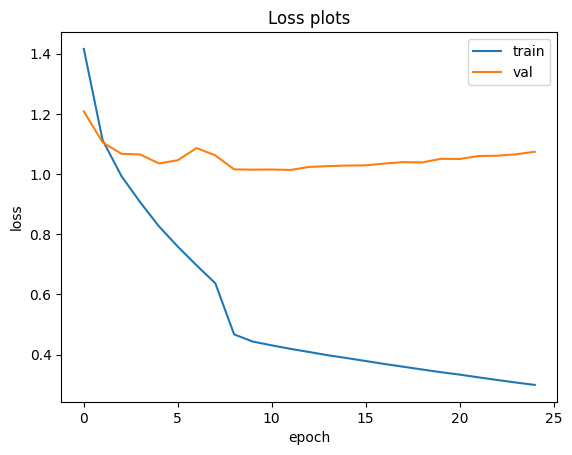

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('Plots/classification_loss.jpg')

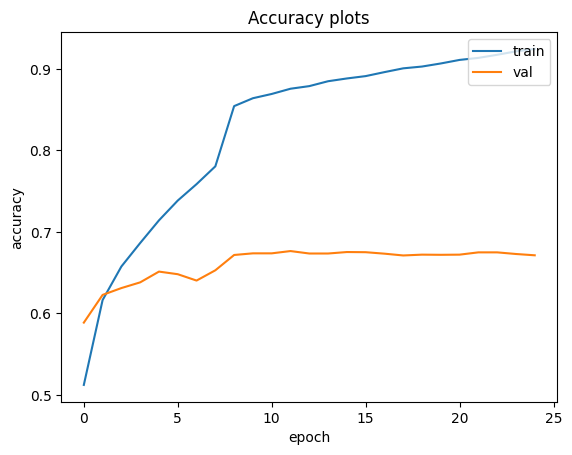

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('Plots/classification_acc.jpg')

# GradCam Analysis

/tmp/ipykernel_1011014/516152623.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

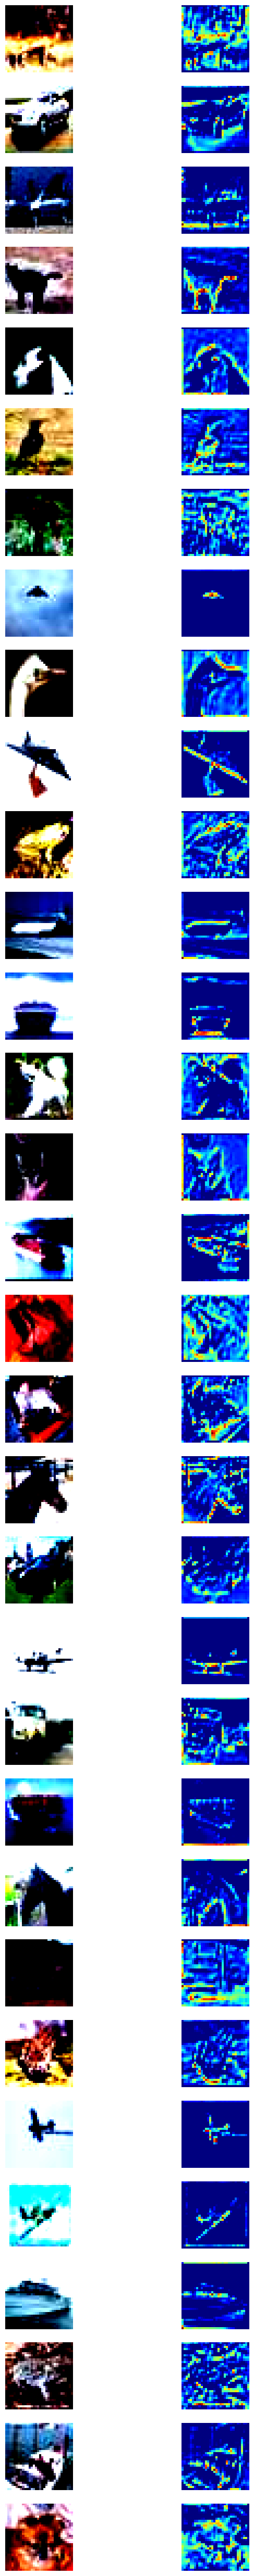

In [67]:

model_to_train.eval()
# GradCAM class
model_to_train = model_to_train.cpu()
device = 'cpu'
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the gradients
        self.h = []
        self.h.append(self.target_layer.register_backward_hook(self.save_gradients))

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, inputs, class_idx=None):

        outputs = self.model(inputs)
        # print(outputs)
        if class_idx is None:
            class_idx = torch.argmax(outputs).item()


        self.model.zero_grad()

        # Backward pass with specified class
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32).to(device)
        one_hot[0][class_idx] = 1
        outputs.backward(gradient=one_hot, retain_graph=True)

        # Get activations
        # print(inputs.shape)
        activations = self.target_layer.forward(inputs)

        # Average the gradients spatially
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute GradCAM map
        grad_cam_map = torch.sum(weights * activations, dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=(inputs.size(2), inputs.size(3)), mode='bilinear', align_corners=False)

        # Remove the anchor to pull information from layers
        for h in self.h:
            h.remove()

        return grad_cam_map

# Visualization function
def visualize_gradcam(img, mask):
    heatmap = (mask - mask.min()) / (mask.max() - mask.min())
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.transpose(heatmap, (1, 2, 0))
    heatmap = np.squeeze(heatmap)

    img = img * 0.5 + 0.5  # Unnormalize
    img = np.uint8(255 * img)
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.show()

# Load a sample image from CIFAR-10 test loader
sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0].unsqueeze(0).to(device)



#please uncomment below line if you have used dataparallel otherwise you will get an error.
# model_to_visualize = model_to_train.module


model_to_visualize = model_to_train

target_layer = model_to_visualize.patch_model.conv1

grad_cam = GradCAM(model_to_visualize, target_layer)



# Load a sample image from CIFAR-10 test loader
sample_imgs, _ = next(iter(test_loader))
sample_imgs = sample_imgs.to('cpu')  # Move images to CPU for Grad-CAM analysis

# Create a subplot for 32 images (adjust the number as needed)
fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(8, 64))

for i in range(32):
    sample_img = sample_imgs[i:i+1]  # Get one image from the batch
    target_class = 0  # Replace with the class index you want to visualize

    # Generate Grad-CAM heatmap for the sample image
    heatmap = grad_cam(sample_img)
    
    if heatmap is not None:
        heatmap = heatmap.squeeze()
        
        # Visualize the original image on the left
        original_image = sample_img.squeeze().detach().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        
        # Visualize the Grad-CAM heatmap on the right
        heatmap_image = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        axes[i, 1].imshow(heatmap_image.detach().numpy(), cmap='jet')
        axes[i, 1].axis('off')

plt.show()